In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
%matplotlib inline
plt.style.use('ggplot')
#mpl.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
train.shape, test.shape

((10886, 12), (6493, 9))

In [10]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape, train.shape

((6493, 13), (10886, 16))

In [12]:
categorical_feature_names = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]

for feature in categorical_feature_names:
    train[feature] = train[feature].astype("category")
    test[feature] = test[feature].astype("category")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null category
month         10886 non-null category
hour          10886 non-null category
dayofweek     10886 non-null category
dtypes: category(8), datetime64[ns](1), float64(3), int64(4)
memory usage: 767.7 KB


In [13]:
feature_names = ["season", "weather", "temp", "atemp", "humidity","year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [14]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [15]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [16]:
label_name = 'count'
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [22]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # add 1 to both predict, actual and sqrt them: why add 1? -> to prevent log value goes negative
    # why log? : to make it normal distribution
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # find the difference square it
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # calculate the mean and sqrt it
    mean_difference = difference.mean()
    score = np.sqrt(mean_difference)
    return score

## Linear Regression Model
- The simplest and oldest regression model
- Pros: no parameter / Cons: it's hard to control model's complexity. 

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

lModel = LinearRegression()

# train the model
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# predict and evaluate
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313504


## Regularization Model - Ridge
- Linear model for regression
- Regularization: Restrict model not to be over-fitting
- set max_iter = 3000

In [27]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_, ridge_params_, scoring = rmsle_scorer, cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780806


## Regularization Model - Lasso
- Lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces [wikipedia]("https://en.wikipedia.org/wiki/Lasso_(statistics)#General_form")
- Feature is automatically chosen
- The default alpha value is 1.0, but we need to reduce it to avoid underfitting
- The best alpha is 0.0025
- set max_iter = 3000

In [29]:

lasso = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV(lasso, lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X_train , y_train_log)
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457641


## Ensemble Model - Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
y_train_log = np.log1p(y_train)
rf.fit(X_train, y_train_log)

predict = rf.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(predict), False)
print ("RMSLE Value For Random Forest: ", score)

RMSLE Value For Random Forest:  0.10729917280389784


## Ensemble Model - Gradient Boost
- **Gradient boosting** is a machine learning technique for both **regression and classification** problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- Fitting the training set too closely can lead to degradation of the model's generalization ability. Several so-called regularization techniques reduce this overfitting effect by constraining the fitting procedure.
- Employing 1~5 tress: predict faster and use less memory
- learning_rate: decide how strong to control error
- As n_estimator increases, more trees will be added to ensemble so the conplexity is higher and we have more opportunity to catch mistakes in train set. But if it's too large, there's possibility that the model would experience overfitting. 

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);
y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)
predict = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(predict),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21357403727249374


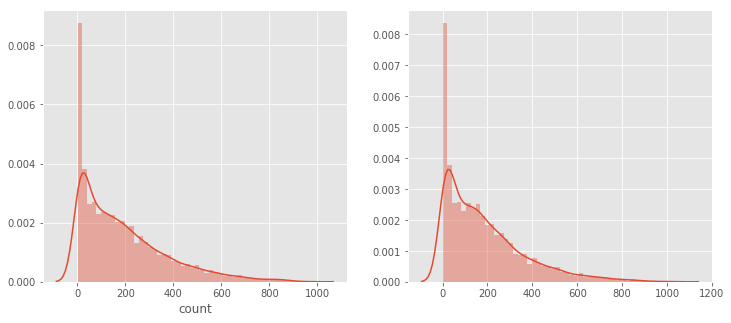

In [36]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sb.distplot(y_train,ax=ax1,bins=50)
sb.distplot(np.exp(predsTest),ax=ax2,bins=50);

## Submission 

In [37]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission["count"] = np.exp(predsTest)
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [38]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)

145/3251*100 = 4.46% <br />
My score is top 4.5%